# Import

In [1]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR
import sys, os

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname("src"))))

from src.Mydataloader import LoadDataset
from src.Mymodel import MyResNet_CIFAR
from src.Mytraining import DoTraining
from src.Earlystopper import EarlyStopper
from src.LogViewer import LogViewer

# Setup

In [2]:
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Dataset parameters"""
BATCH = 128
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True
SPLIT_RATIO = 0

"""optimizer parameters"""
# OPTIMIZER = "Adam"
# OPTIMIZER = "Adam_decay"
OPTIMIZER = "SGD"
# OPTIMIZER = "SGD_nasterov"
# OPTIMIZER = "AdamW"
# OPTIMIZER = "AdamW_amsgrad"
# OPTIMIZER = "NAdam"

"""Learning rate scheduler parameters"""
NUM_EPOCHS = 200

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = 100

file_name = f"MyResNet32_{BATCH}_{OPTIMIZER}"

In [3]:
file_name

'MyResNet32_128_SGD'

# Loading the dataset

## Define Dateloader

In [4]:
tmp = LoadDataset(root="../../data", seceted_dataset=DATASET, split_ratio=SPLIT_RATIO)
train_data, valid_data, test_data, COUNT_OF_CLASSES = tmp.Unpack()

/home/lee/anaconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


-----------------------------------------------------------------------
Dataset :  CIFAR10
- Length of Train Set :  50000
- Length of Test Set :  10000
- Count of Classes :  10
-----------------------------------------------------------------------


In [5]:
train_dataloader, valid_dataloader, test_dataloader = tmp.get_dataloader(
    batch_size=BATCH, shuffle=SHUFFLE, num_workers=NUMOFWORKERS, pin_memory=PIN_MEMORY
)

train.transforms = Compose(
      AutoAugment(interpolation=InterpolationMode.NEAREST, policy=AutoAugmentPolicy.CIFAR10)
      RandomCrop(size=(32, 32), padding=[4, 4, 4, 4], pad_if_needed=False, fill=0, padding_mode=constant)
      RandomHorizontalFlip(p=0.5)
      ToTensor()
      Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[1, 1, 1], inplace=True)
) 128
test.transforms = ToTensor() 128


# Define ResNet

## Model Confirm

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
model = MyResNet_CIFAR(num_classes=COUNT_OF_CLASSES, num_layer_factor=5).to(device)

# Define Training

## (1) Define Criterion

In [8]:
criterion = nn.CrossEntropyLoss()

## (2) Define Optimazer

In [9]:
if OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
elif OPTIMIZER == "Adam_decay":
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001
    )
elif OPTIMIZER == "SGD_nasterov":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4, nesterov=True
    )
elif OPTIMIZER == "AdamW":
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "AdamW_amsgrad":
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4, amsgrad=True)
elif OPTIMIZER == "NAdam":
    optimizer = torch.optim.NAdam(model.parameters(), weight_decay=1e-4)

## (3) Define Early Stopping

In [10]:
earlystopper = EarlyStopper(patience=EARLYSTOPPINGPATIENCE, model=model, file_name=file_name)

## (4) Define Learning Rate schedualer

In [11]:
# scheduler = ExponentialLR(optimizer, gamma=0.95)
scheduler = MultiStepLR(optimizer, milestones=[82, 123], gamma=0.1)
"""
=======================================================
if batch = 256
=======================================================
non-split [single epoch = 196 iter] : milestones = [164, 246]
- 1 ~ 164 epochs == 1 ~ 32k iter >> lr = 0.1
- 165~246 epochs == 32k ~ 48k iter >> lr = 0.01
- 247~328(?) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
split to 45k/5k [single epoch = 176 iter]: milestones = [182, 273]
- 1~182 epochs == 1 ~ 32k iter >> lr = 0.1
- 182~273 epochs == 32k ~ 48k iter >> lr = 0.01
- 273~364(?) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
if batch = 128
=======================================================
non-split [signle epoch = 391 iter]: milestones = [82, 123]
- 1 ~ 82 epochs == 1 ~ 32k iter >> lr = 0.1
- 83~123 epochs == 32k ~ 48k iter >> lr = 0.01
- 124~(164) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
split to 45k/5k [signle epoch = 352 iter]: milestones = [91, 137]
- 1~91 epochs == 1 ~ 32k iter >> lr = 0.1
- 92~137 epochs == 32k ~ 48k iter >> lr = 0.01
- 138~(183) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
"""

'\n=======================================================\nif batch = 256\n=======================================================\nnon-split [single epoch = 196 iter] : milestones = [164, 246]\n- 1 ~ 164 epochs == 1 ~ 32k iter >> lr = 0.1\n- 165~246 epochs == 32k ~ 48k iter >> lr = 0.01\n- 247~328(?) epochs == 48k ~ 64k iter >> lr = 0.001\n=======================================================\nsplit to 45k/5k [single epoch = 176 iter]: milestones = [182, 273]\n- 1~182 epochs == 1 ~ 32k iter >> lr = 0.1\n- 182~273 epochs == 32k ~ 48k iter >> lr = 0.01\n- 273~364(?) epochs == 48k ~ 64k iter >> lr = 0.001\n=======================================================\nif batch = 128\n=======================================================\nnon-split [signle epoch = 391 iter]: milestones = [82, 123]\n- 1 ~ 82 epochs == 1 ~ 32k iter >> lr = 0.1\n- 83~123 epochs == 32k ~ 48k iter >> lr = 0.01\n- 124~(164) epochs == 48k ~ 64k iter >> lr = 0.001\n=================================================

## (5) Define AMP scaler

In [12]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

## Load before process

In [13]:
if os.path.exists(file_name + ".pth.tar"):
    # Read checkpoint as desired, e.g.,
    checkpoint = torch.load(
        file_name + ".pth.tar",
        map_location=lambda storage, loc: storage.cuda(device),
    )
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scaler.load_state_dict(checkpoint["scaler"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    earlystopper.load_state_dict(checkpoint["earlystopper"])
    logs = checkpoint["logs"]

    print("Suceessfully loaded the All setting and Log file.")
    print(file_name)
    print(f"Current epoch is {len(logs['train_loss'])}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
else:
    # Create a dictionary to store the variables
    train_loss = []
    train_acc = []
    eval_loss = []
    valid_acc = []
    test_loss = []
    test_acc = []
    lr_log = []
    logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "valid_loss": eval_loss,
        "valid_acc": valid_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "lr_log": lr_log,
    }
    print("File does not exist. Created a new log.")

File does not exist. Created a new log.


In [14]:
optimizer.param_groups[0]["lr"]

0.1

In [15]:
earlystopper.early_stop_counter

0

# [Training Loop]

In [16]:
Training = DoTraining(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler=scheduler,
    earlystopper=earlystopper,
    device=device,
    logs=logs,
    file_path=file_name,
)
pre_epochs = len(Training.logs["train_loss"])


for epoch in range(NUM_EPOCHS):
    now = epoch + 1 + pre_epochs
    print(f"[Epoch {epoch+1+pre_epochs}/{NUM_EPOCHS}] :")

    if DATASET == "ImageNet2012":
        eval_loss = Training.SingleEpoch(train_dataloader, valid_dataloader)
    else:
        eval_loss = Training.SingleEpoch(
            train_dataloader, valid_dataloader, test_dataloader
        )

    Training.Save()

    
    
    if earlystopper.check(eval_loss) == True:
        break

    print("-" * 50)

[Epoch 1/200] :


1 Train: 100%|███████| 391/391 [00:07<00:00, 53.93it/s]

Train Loss: 2.3735 | Train Acc: 13.14%


Test  Loss: 2.1853 | Test Acc: 13.33%
updated best eval loss : 2.185300320009642
--------------------------------------------------
[Epoch 2/200] :


2 Train: 100%|███████| 391/391 [00:05<00:00, 69.87it/s]


Train Loss: 2.0798 | Train Acc: 21.48%
Test  Loss: 2.3546 | Test Acc: 22.18%
--------------------------------------------------
[Epoch 3/200] :


3 Train: 100%|███████| 391/391 [00:05<00:00, 67.81it/s]


Train Loss: 1.8352 | Train Acc: 31.53%
Test  Loss: 2.1068 | Test Acc: 31.82%
updated best eval loss : 2.1068113997012756
--------------------------------------------------
[Epoch 4/200] :


4 Train: 100%|███████| 391/391 [00:05<00:00, 66.37it/s]


Train Loss: 1.5061 | Train Acc: 45.79%
Test  Loss: 1.7083 | Test Acc: 45.61%
updated best eval loss : 1.7082814370529562
--------------------------------------------------
[Epoch 5/200] :


5 Train: 100%|███████| 391/391 [00:05<00:00, 67.94it/s]


Train Loss: 1.2799 | Train Acc: 54.32%
Test  Loss: 1.4064 | Test Acc: 54.87%
updated best eval loss : 1.406367553185813
--------------------------------------------------
[Epoch 6/200] :


6 Train: 100%|███████| 391/391 [00:05<00:00, 69.47it/s]


Train Loss: 1.1260 | Train Acc: 60.35%
Test  Loss: 1.7006 | Test Acc: 46.35%
--------------------------------------------------
[Epoch 7/200] :


7 Train: 100%|███████| 391/391 [00:05<00:00, 68.35it/s]


Train Loss: 1.0174 | Train Acc: 64.24%
Test  Loss: 1.5005 | Test Acc: 52.57%
--------------------------------------------------
[Epoch 8/200] :


8 Train: 100%|███████| 391/391 [00:05<00:00, 66.38it/s]


Train Loss: 0.9513 | Train Acc: 66.92%
Test  Loss: 1.0685 | Test Acc: 63.46%
updated best eval loss : 1.068510890007019
--------------------------------------------------
[Epoch 9/200] :


9 Train: 100%|███████| 391/391 [00:05<00:00, 66.54it/s]


Train Loss: 0.8944 | Train Acc: 68.88%
Test  Loss: 0.9583 | Test Acc: 67.55%
updated best eval loss : 0.9582502313807041
--------------------------------------------------
[Epoch 10/200] :


10 Train: 100%|██████| 391/391 [00:05<00:00, 65.86it/s]


Train Loss: 0.8420 | Train Acc: 70.80%
Test  Loss: 0.9658 | Test Acc: 67.72%
--------------------------------------------------
[Epoch 11/200] :


11 Train: 100%|██████| 391/391 [00:06<00:00, 64.96it/s]


Train Loss: 0.7979 | Train Acc: 72.54%
Test  Loss: 0.8477 | Test Acc: 71.89%
updated best eval loss : 0.8477379875847056
--------------------------------------------------
[Epoch 12/200] :


12 Train: 100%|██████| 391/391 [00:06<00:00, 65.13it/s]


Train Loss: 0.7740 | Train Acc: 73.02%
Test  Loss: 0.7888 | Test Acc: 72.95%
updated best eval loss : 0.7888479051710684
--------------------------------------------------
[Epoch 13/200] :


13 Train: 100%|██████| 391/391 [00:05<00:00, 65.55it/s]


Train Loss: 0.7439 | Train Acc: 73.92%
Test  Loss: 0.6807 | Test Acc: 76.76%
updated best eval loss : 0.6807032487814939
--------------------------------------------------
[Epoch 14/200] :


14 Train: 100%|██████| 391/391 [00:05<00:00, 67.89it/s]


Train Loss: 0.7233 | Train Acc: 74.83%
Test  Loss: 0.7870 | Test Acc: 72.86%
--------------------------------------------------
[Epoch 15/200] :


15 Train: 100%|██████| 391/391 [00:05<00:00, 69.52it/s]


Train Loss: 0.7041 | Train Acc: 75.55%
Test  Loss: 0.8039 | Test Acc: 73.14%
--------------------------------------------------
[Epoch 16/200] :


16 Train: 100%|██████| 391/391 [00:05<00:00, 69.84it/s]


Train Loss: 0.6846 | Train Acc: 76.25%
Test  Loss: 0.8535 | Test Acc: 72.21%
--------------------------------------------------
[Epoch 17/200] :


17 Train: 100%|██████| 391/391 [00:05<00:00, 68.66it/s]


Train Loss: 0.6701 | Train Acc: 76.94%
Test  Loss: 0.7460 | Test Acc: 74.92%
--------------------------------------------------
[Epoch 18/200] :


18 Train: 100%|██████| 391/391 [00:05<00:00, 69.35it/s]


Train Loss: 0.6563 | Train Acc: 77.19%
Test  Loss: 0.7131 | Test Acc: 75.71%
--------------------------------------------------
[Epoch 19/200] :


19 Train: 100%|██████| 391/391 [00:05<00:00, 66.19it/s]


Train Loss: 0.6436 | Train Acc: 77.59%
Test  Loss: 0.8578 | Test Acc: 71.80%
--------------------------------------------------
[Epoch 20/200] :


20 Train: 100%|██████| 391/391 [00:06<00:00, 64.53it/s]


Train Loss: 0.6298 | Train Acc: 78.08%
Test  Loss: 0.6139 | Test Acc: 79.67%
updated best eval loss : 0.6139429785028289
--------------------------------------------------
[Epoch 21/200] :


21 Train: 100%|██████| 391/391 [00:05<00:00, 67.96it/s]


Train Loss: 0.6198 | Train Acc: 78.50%
Test  Loss: 0.6567 | Test Acc: 77.71%
--------------------------------------------------
[Epoch 22/200] :


22 Train: 100%|██████| 391/391 [00:05<00:00, 68.17it/s]


Train Loss: 0.6154 | Train Acc: 78.68%
Test  Loss: 0.6426 | Test Acc: 77.83%
--------------------------------------------------
[Epoch 23/200] :


23 Train: 100%|██████| 391/391 [00:06<00:00, 64.83it/s]


Train Loss: 0.6020 | Train Acc: 78.97%
Test  Loss: 0.7544 | Test Acc: 75.17%
--------------------------------------------------
[Epoch 24/200] :


24 Train: 100%|██████| 391/391 [00:05<00:00, 65.53it/s]


Train Loss: 0.5903 | Train Acc: 79.72%
Test  Loss: 0.7728 | Test Acc: 75.12%
--------------------------------------------------
[Epoch 25/200] :


25 Train: 100%|██████| 391/391 [00:06<00:00, 63.31it/s]


Train Loss: 0.5854 | Train Acc: 79.76%
Test  Loss: 0.6401 | Test Acc: 78.14%
--------------------------------------------------
[Epoch 26/200] :


26 Train: 100%|██████| 391/391 [00:05<00:00, 65.38it/s]


Train Loss: 0.5769 | Train Acc: 80.00%
Test  Loss: 0.9321 | Test Acc: 69.31%
--------------------------------------------------
[Epoch 27/200] :


27 Train: 100%|██████| 391/391 [00:05<00:00, 66.29it/s]


Train Loss: 0.5654 | Train Acc: 80.46%
Test  Loss: 0.8765 | Test Acc: 71.12%
--------------------------------------------------
[Epoch 28/200] :


28 Train: 100%|██████| 391/391 [00:05<00:00, 66.55it/s]


Train Loss: 0.5637 | Train Acc: 80.45%
Test  Loss: 0.6035 | Test Acc: 79.29%
updated best eval loss : 0.603456699018237
--------------------------------------------------
[Epoch 29/200] :


29 Train: 100%|██████| 391/391 [00:05<00:00, 68.29it/s]


Train Loss: 0.5577 | Train Acc: 80.65%
Test  Loss: 0.7361 | Test Acc: 75.99%
--------------------------------------------------
[Epoch 30/200] :


30 Train: 100%|██████| 391/391 [00:05<00:00, 68.88it/s]


Train Loss: 0.5488 | Train Acc: 81.01%
Test  Loss: 0.5454 | Test Acc: 81.25%
updated best eval loss : 0.5454215505455113
--------------------------------------------------
[Epoch 31/200] :


31 Train: 100%|██████| 391/391 [00:05<00:00, 67.36it/s]


Train Loss: 0.5549 | Train Acc: 80.88%
Test  Loss: 0.9260 | Test Acc: 70.73%
--------------------------------------------------
[Epoch 32/200] :


32 Train: 100%|██████| 391/391 [00:05<00:00, 67.14it/s]


Train Loss: 0.5415 | Train Acc: 81.32%
Test  Loss: 0.8609 | Test Acc: 73.45%
--------------------------------------------------
[Epoch 33/200] :


33 Train: 100%|██████| 391/391 [00:05<00:00, 68.15it/s]


Train Loss: 0.5409 | Train Acc: 81.13%
Test  Loss: 0.6153 | Test Acc: 79.66%
--------------------------------------------------
[Epoch 34/200] :


34 Train: 100%|██████| 391/391 [00:05<00:00, 67.74it/s]


Train Loss: 0.5332 | Train Acc: 81.51%
Test  Loss: 0.6329 | Test Acc: 79.53%
--------------------------------------------------
[Epoch 35/200] :


35 Train: 100%|██████| 391/391 [00:05<00:00, 66.11it/s]


Train Loss: 0.5261 | Train Acc: 81.62%
Test  Loss: 0.5948 | Test Acc: 79.90%
--------------------------------------------------
[Epoch 36/200] :


36 Train: 100%|██████| 391/391 [00:05<00:00, 65.91it/s]


Train Loss: 0.5218 | Train Acc: 82.02%
Test  Loss: 0.5871 | Test Acc: 79.96%
--------------------------------------------------
[Epoch 37/200] :


37 Train: 100%|██████| 391/391 [00:05<00:00, 68.16it/s]


Train Loss: 0.5237 | Train Acc: 81.66%
Test  Loss: 0.5833 | Test Acc: 80.39%
--------------------------------------------------
[Epoch 38/200] :


38 Train: 100%|██████| 391/391 [00:05<00:00, 67.88it/s]


Train Loss: 0.5129 | Train Acc: 82.12%
Test  Loss: 0.6289 | Test Acc: 79.63%
--------------------------------------------------
[Epoch 39/200] :


39 Train: 100%|██████| 391/391 [00:05<00:00, 66.84it/s]


Train Loss: 0.5128 | Train Acc: 82.22%
Test  Loss: 0.6011 | Test Acc: 80.30%
--------------------------------------------------
[Epoch 40/200] :


40 Train: 100%|██████| 391/391 [00:05<00:00, 66.05it/s]


Train Loss: 0.5081 | Train Acc: 82.42%
Test  Loss: 0.6805 | Test Acc: 78.96%
--------------------------------------------------
[Epoch 41/200] :


41 Train: 100%|██████| 391/391 [00:05<00:00, 65.77it/s]


Train Loss: 0.5044 | Train Acc: 82.56%
Test  Loss: 0.7503 | Test Acc: 75.89%
--------------------------------------------------
[Epoch 42/200] :


42 Train: 100%|██████| 391/391 [00:05<00:00, 65.78it/s]


Train Loss: 0.4997 | Train Acc: 82.52%
Test  Loss: 0.7247 | Test Acc: 75.73%
--------------------------------------------------
[Epoch 43/200] :


43 Train: 100%|██████| 391/391 [00:05<00:00, 65.96it/s]


Train Loss: 0.4918 | Train Acc: 83.15%
Test  Loss: 0.8897 | Test Acc: 72.06%
--------------------------------------------------
[Epoch 44/200] :


44 Train: 100%|██████| 391/391 [00:05<00:00, 68.39it/s]


Train Loss: 0.4968 | Train Acc: 82.82%
Test  Loss: 0.5915 | Test Acc: 79.96%
--------------------------------------------------
[Epoch 45/200] :


45 Train: 100%|██████| 391/391 [00:05<00:00, 69.47it/s]


Train Loss: 0.4950 | Train Acc: 82.84%
Test  Loss: 0.7306 | Test Acc: 76.40%
--------------------------------------------------
[Epoch 46/200] :


46 Train: 100%|██████| 391/391 [00:05<00:00, 69.49it/s]


Train Loss: 0.4885 | Train Acc: 82.93%
Test  Loss: 0.5809 | Test Acc: 81.01%
--------------------------------------------------
[Epoch 47/200] :


47 Train: 100%|██████| 391/391 [00:05<00:00, 68.92it/s]


Train Loss: 0.4793 | Train Acc: 83.42%
Test  Loss: 0.6987 | Test Acc: 77.51%
--------------------------------------------------
[Epoch 48/200] :


48 Train: 100%|██████| 391/391 [00:05<00:00, 67.48it/s]


Train Loss: 0.4853 | Train Acc: 83.06%
Test  Loss: 0.8283 | Test Acc: 72.72%
--------------------------------------------------
[Epoch 49/200] :


49 Train: 100%|██████| 391/391 [00:05<00:00, 68.03it/s]


Train Loss: 0.4836 | Train Acc: 83.25%
Test  Loss: 0.6775 | Test Acc: 77.47%
--------------------------------------------------
[Epoch 50/200] :


50 Train: 100%|██████| 391/391 [00:05<00:00, 65.40it/s]


Train Loss: 0.4813 | Train Acc: 83.19%
Test  Loss: 0.6467 | Test Acc: 78.43%
--------------------------------------------------
[Epoch 51/200] :


51 Train: 100%|██████| 391/391 [00:05<00:00, 66.36it/s]


Train Loss: 0.4721 | Train Acc: 83.54%
Test  Loss: 0.6415 | Test Acc: 78.52%
--------------------------------------------------
[Epoch 52/200] :


52 Train: 100%|██████| 391/391 [00:05<00:00, 68.34it/s]


Train Loss: 0.4667 | Train Acc: 83.80%
Test  Loss: 0.6146 | Test Acc: 79.19%
--------------------------------------------------
[Epoch 53/200] :


53 Train: 100%|██████| 391/391 [00:05<00:00, 65.84it/s]


Train Loss: 0.4717 | Train Acc: 83.72%
Test  Loss: 0.6307 | Test Acc: 79.34%
--------------------------------------------------
[Epoch 54/200] :


54 Train: 100%|██████| 391/391 [00:06<00:00, 64.82it/s]


Train Loss: 0.4654 | Train Acc: 83.74%
Test  Loss: 0.6336 | Test Acc: 79.36%
--------------------------------------------------
[Epoch 55/200] :


55 Train: 100%|██████| 391/391 [00:06<00:00, 63.83it/s]


Train Loss: 0.4658 | Train Acc: 83.72%
Test  Loss: 0.5362 | Test Acc: 81.75%
updated best eval loss : 0.5362161880807031
--------------------------------------------------
[Epoch 56/200] :


56 Train: 100%|██████| 391/391 [00:06<00:00, 65.08it/s]


Train Loss: 0.4637 | Train Acc: 83.81%
Test  Loss: 0.6526 | Test Acc: 78.66%
--------------------------------------------------
[Epoch 57/200] :


57 Train: 100%|██████| 391/391 [00:05<00:00, 65.86it/s]


Train Loss: 0.4631 | Train Acc: 83.98%
Test  Loss: 0.6273 | Test Acc: 78.51%
--------------------------------------------------
[Epoch 58/200] :


58 Train: 100%|██████| 391/391 [00:05<00:00, 65.49it/s]


Train Loss: 0.4649 | Train Acc: 83.74%
Test  Loss: 1.1902 | Test Acc: 67.72%
--------------------------------------------------
[Epoch 59/200] :


59 Train: 100%|██████| 391/391 [00:05<00:00, 66.50it/s]


Train Loss: 0.4586 | Train Acc: 84.16%
Test  Loss: 0.5757 | Test Acc: 81.11%
--------------------------------------------------
[Epoch 60/200] :


60 Train: 100%|██████| 391/391 [00:05<00:00, 68.67it/s]


Train Loss: 0.4518 | Train Acc: 84.15%
Test  Loss: 0.7253 | Test Acc: 75.87%
--------------------------------------------------
[Epoch 61/200] :


61 Train: 100%|██████| 391/391 [00:05<00:00, 69.30it/s]


Train Loss: 0.4629 | Train Acc: 83.97%
Test  Loss: 0.9303 | Test Acc: 70.60%
--------------------------------------------------
[Epoch 62/200] :


62 Train: 100%|██████| 391/391 [00:05<00:00, 69.51it/s]


Train Loss: 0.4518 | Train Acc: 84.23%
Test  Loss: 0.7156 | Test Acc: 75.63%
--------------------------------------------------
[Epoch 63/200] :


63 Train: 100%|██████| 391/391 [00:05<00:00, 69.37it/s]


Train Loss: 0.4601 | Train Acc: 83.91%
Test  Loss: 0.5983 | Test Acc: 80.67%
--------------------------------------------------
[Epoch 64/200] :


64 Train: 100%|██████| 391/391 [00:05<00:00, 67.14it/s]


Train Loss: 0.4477 | Train Acc: 84.25%
Test  Loss: 0.6035 | Test Acc: 80.41%
--------------------------------------------------
[Epoch 65/200] :


65 Train: 100%|██████| 391/391 [00:05<00:00, 65.83it/s]


Train Loss: 0.4496 | Train Acc: 84.37%
Test  Loss: 0.5615 | Test Acc: 81.12%
--------------------------------------------------
[Epoch 66/200] :


66 Train: 100%|██████| 391/391 [00:05<00:00, 66.98it/s]


Train Loss: 0.4470 | Train Acc: 84.52%
Test  Loss: 0.6118 | Test Acc: 79.74%
--------------------------------------------------
[Epoch 67/200] :


67 Train: 100%|██████| 391/391 [00:05<00:00, 67.60it/s]


Train Loss: 0.4503 | Train Acc: 84.37%
Test  Loss: 0.7235 | Test Acc: 76.07%
--------------------------------------------------
[Epoch 68/200] :


68 Train: 100%|██████| 391/391 [00:05<00:00, 68.39it/s]


Train Loss: 0.4450 | Train Acc: 84.49%
Test  Loss: 0.7428 | Test Acc: 76.09%
--------------------------------------------------
[Epoch 69/200] :


69 Train: 100%|██████| 391/391 [00:05<00:00, 66.24it/s]


Train Loss: 0.4390 | Train Acc: 84.68%
Test  Loss: 0.5916 | Test Acc: 79.45%
--------------------------------------------------
[Epoch 70/200] :


70 Train: 100%|██████| 391/391 [00:06<00:00, 65.06it/s]


Train Loss: 0.4397 | Train Acc: 84.69%
Test  Loss: 0.5885 | Test Acc: 80.43%
--------------------------------------------------
[Epoch 71/200] :


71 Train: 100%|██████| 391/391 [00:06<00:00, 64.07it/s]


Train Loss: 0.4427 | Train Acc: 84.49%
Test  Loss: 0.5730 | Test Acc: 81.05%
--------------------------------------------------
[Epoch 72/200] :


72 Train: 100%|██████| 391/391 [00:05<00:00, 65.60it/s]


Train Loss: 0.4382 | Train Acc: 84.85%
Test  Loss: 0.8778 | Test Acc: 73.55%
--------------------------------------------------
[Epoch 73/200] :


73 Train: 100%|██████| 391/391 [00:05<00:00, 65.78it/s]


Train Loss: 0.4430 | Train Acc: 84.57%
Test  Loss: 0.6363 | Test Acc: 78.59%
--------------------------------------------------
[Epoch 74/200] :


74 Train: 100%|██████| 391/391 [00:05<00:00, 66.14it/s]


Train Loss: 0.4340 | Train Acc: 84.86%
Test  Loss: 0.6836 | Test Acc: 79.23%
--------------------------------------------------
[Epoch 75/200] :


75 Train: 100%|██████| 391/391 [00:05<00:00, 69.27it/s]


Train Loss: 0.4363 | Train Acc: 84.62%
Test  Loss: 0.5708 | Test Acc: 81.95%
--------------------------------------------------
[Epoch 76/200] :


76 Train: 100%|██████| 391/391 [00:05<00:00, 69.62it/s]


Train Loss: 0.4346 | Train Acc: 84.87%
Test  Loss: 0.5632 | Test Acc: 81.52%
--------------------------------------------------
[Epoch 77/200] :


77 Train: 100%|██████| 391/391 [00:05<00:00, 68.12it/s]


Train Loss: 0.4297 | Train Acc: 85.06%
Test  Loss: 0.5309 | Test Acc: 82.42%
updated best eval loss : 0.5309174241898935
--------------------------------------------------
[Epoch 78/200] :


78 Train: 100%|██████| 391/391 [00:05<00:00, 70.30it/s]


Train Loss: 0.4327 | Train Acc: 84.89%
Test  Loss: 0.6169 | Test Acc: 79.50%
--------------------------------------------------
[Epoch 79/200] :


79 Train: 100%|██████| 391/391 [00:05<00:00, 68.27it/s]


Train Loss: 0.4262 | Train Acc: 85.27%
Test  Loss: 0.6141 | Test Acc: 80.04%
--------------------------------------------------
[Epoch 80/200] :


80 Train: 100%|██████| 391/391 [00:06<00:00, 64.17it/s]


Train Loss: 0.4284 | Train Acc: 84.99%
Test  Loss: 0.6411 | Test Acc: 78.76%
--------------------------------------------------
[Epoch 81/200] :


81 Train: 100%|██████| 391/391 [00:05<00:00, 66.17it/s]


Train Loss: 0.4330 | Train Acc: 84.94%
Test  Loss: 0.6459 | Test Acc: 78.46%
--------------------------------------------------
[Epoch 82/200] :


82 Train: 100%|██████| 391/391 [00:05<00:00, 68.16it/s]


Train Loss: 0.4254 | Train Acc: 85.15%
Test  Loss: 0.5410 | Test Acc: 82.23%
Learning Rate has changed : Now is 0.010000000000000002
--------------------------------------------------
[Epoch 83/200] :


83 Train: 100%|██████| 391/391 [00:05<00:00, 66.10it/s]


Train Loss: 0.3360 | Train Acc: 88.18%
Test  Loss: 0.4116 | Test Acc: 86.13%
updated best eval loss : 0.4116376264940334
--------------------------------------------------
[Epoch 84/200] :


84 Train: 100%|██████| 391/391 [00:05<00:00, 66.79it/s]


Train Loss: 0.3007 | Train Acc: 89.49%
Test  Loss: 0.3711 | Test Acc: 87.59%
updated best eval loss : 0.37109410781649094
--------------------------------------------------
[Epoch 85/200] :


85 Train: 100%|██████| 391/391 [00:05<00:00, 65.60it/s]


Train Loss: 0.2922 | Train Acc: 89.75%
Test  Loss: 0.3863 | Test Acc: 86.97%
--------------------------------------------------
[Epoch 86/200] :


86 Train: 100%|██████| 391/391 [00:05<00:00, 66.41it/s]


Train Loss: 0.2886 | Train Acc: 89.98%
Test  Loss: 0.4117 | Test Acc: 86.60%
--------------------------------------------------
[Epoch 87/200] :


87 Train: 100%|██████| 391/391 [00:05<00:00, 65.33it/s]


Train Loss: 0.2780 | Train Acc: 90.27%
Test  Loss: 0.4053 | Test Acc: 86.66%
--------------------------------------------------
[Epoch 88/200] :


88 Train: 100%|██████| 391/391 [00:06<00:00, 64.44it/s]


Train Loss: 0.2757 | Train Acc: 90.38%
Test  Loss: 0.4036 | Test Acc: 86.35%
--------------------------------------------------
[Epoch 89/200] :


89 Train: 100%|██████| 391/391 [00:06<00:00, 63.73it/s]


Train Loss: 0.2715 | Train Acc: 90.49%
Test  Loss: 0.4268 | Test Acc: 85.92%
--------------------------------------------------
[Epoch 90/200] :


90 Train: 100%|██████| 391/391 [00:05<00:00, 68.69it/s]


Train Loss: 0.2672 | Train Acc: 90.73%
Test  Loss: 0.3838 | Test Acc: 87.59%
--------------------------------------------------
[Epoch 91/200] :


91 Train: 100%|██████| 391/391 [00:05<00:00, 68.08it/s]


Train Loss: 0.2583 | Train Acc: 90.93%
Test  Loss: 0.4166 | Test Acc: 86.52%
--------------------------------------------------
[Epoch 92/200] :


92 Train: 100%|██████| 391/391 [00:05<00:00, 69.63it/s]


Train Loss: 0.2600 | Train Acc: 90.96%
Test  Loss: 0.4318 | Test Acc: 85.97%
--------------------------------------------------
[Epoch 93/200] :


93 Train: 100%|██████| 391/391 [00:05<00:00, 70.35it/s]


Train Loss: 0.2551 | Train Acc: 91.09%
Test  Loss: 0.4255 | Test Acc: 85.72%
--------------------------------------------------
[Epoch 94/200] :


94 Train: 100%|██████| 391/391 [00:05<00:00, 69.60it/s]


Train Loss: 0.2588 | Train Acc: 90.92%
Test  Loss: 0.4461 | Test Acc: 85.42%
--------------------------------------------------
[Epoch 95/200] :


95 Train: 100%|██████| 391/391 [00:05<00:00, 67.21it/s]


Train Loss: 0.2504 | Train Acc: 91.33%
Test  Loss: 0.4324 | Test Acc: 85.90%
--------------------------------------------------
[Epoch 96/200] :


96 Train: 100%|██████| 391/391 [00:06<00:00, 63.92it/s]


Train Loss: 0.2460 | Train Acc: 91.54%
Test  Loss: 0.4710 | Test Acc: 84.72%
--------------------------------------------------
[Epoch 97/200] :


97 Train: 100%|██████| 391/391 [00:05<00:00, 67.53it/s]


Train Loss: 0.2569 | Train Acc: 90.97%
Test  Loss: 0.4522 | Test Acc: 85.16%
--------------------------------------------------
[Epoch 98/200] :


98 Train: 100%|██████| 391/391 [00:05<00:00, 66.54it/s]


Train Loss: 0.2494 | Train Acc: 91.28%
Test  Loss: 0.4727 | Test Acc: 84.57%
--------------------------------------------------
[Epoch 99/200] :


99 Train: 100%|██████| 391/391 [00:05<00:00, 66.13it/s]


Train Loss: 0.2461 | Train Acc: 91.36%
Test  Loss: 0.4668 | Test Acc: 85.11%
--------------------------------------------------
[Epoch 100/200] :


100 Train: 100%|█████| 391/391 [00:06<00:00, 64.00it/s]


Train Loss: 0.2439 | Train Acc: 91.48%
Test  Loss: 0.4372 | Test Acc: 85.40%
--------------------------------------------------
[Epoch 101/200] :


101 Train: 100%|█████| 391/391 [00:05<00:00, 66.38it/s]


Train Loss: 0.2407 | Train Acc: 91.40%
Test  Loss: 0.4563 | Test Acc: 85.20%
--------------------------------------------------
[Epoch 102/200] :


102 Train: 100%|█████| 391/391 [00:05<00:00, 65.79it/s]


Train Loss: 0.2403 | Train Acc: 91.43%
Test  Loss: 0.4814 | Test Acc: 84.75%
--------------------------------------------------
[Epoch 103/200] :


103 Train: 100%|█████| 391/391 [00:06<00:00, 64.39it/s]


Train Loss: 0.2383 | Train Acc: 91.67%
Test  Loss: 0.4667 | Test Acc: 85.10%
--------------------------------------------------
[Epoch 104/200] :


104 Train: 100%|█████| 391/391 [00:06<00:00, 62.79it/s]


Train Loss: 0.2425 | Train Acc: 91.57%
Test  Loss: 0.4322 | Test Acc: 85.57%
--------------------------------------------------
[Epoch 105/200] :


105 Train: 100%|█████| 391/391 [00:05<00:00, 67.05it/s]


Train Loss: 0.2316 | Train Acc: 91.89%
Test  Loss: 0.4398 | Test Acc: 85.92%
--------------------------------------------------
[Epoch 106/200] :


106 Train: 100%|█████| 391/391 [00:05<00:00, 69.77it/s]


Train Loss: 0.2349 | Train Acc: 91.82%
Test  Loss: 0.4416 | Test Acc: 85.73%
--------------------------------------------------
[Epoch 107/200] :


107 Train: 100%|█████| 391/391 [00:05<00:00, 69.11it/s]


Train Loss: 0.2367 | Train Acc: 91.67%
Test  Loss: 0.4362 | Test Acc: 85.99%
--------------------------------------------------
[Epoch 108/200] :


108 Train: 100%|█████| 391/391 [00:05<00:00, 70.10it/s]


Train Loss: 0.2285 | Train Acc: 92.01%
Test  Loss: 0.4573 | Test Acc: 85.35%
--------------------------------------------------
[Epoch 109/200] :


109 Train: 100%|█████| 391/391 [00:05<00:00, 68.98it/s]


Train Loss: 0.2318 | Train Acc: 91.87%
Test  Loss: 0.4452 | Test Acc: 85.40%
--------------------------------------------------
[Epoch 110/200] :


110 Train: 100%|█████| 391/391 [00:05<00:00, 67.27it/s]


Train Loss: 0.2275 | Train Acc: 92.14%
Test  Loss: 0.4392 | Test Acc: 86.15%
--------------------------------------------------
[Epoch 111/200] :


111 Train: 100%|█████| 391/391 [00:05<00:00, 65.41it/s]


Train Loss: 0.2284 | Train Acc: 91.98%
Test  Loss: 0.4670 | Test Acc: 85.49%
--------------------------------------------------
[Epoch 112/200] :


112 Train: 100%|█████| 391/391 [00:05<00:00, 66.21it/s]


Train Loss: 0.2295 | Train Acc: 92.04%
Test  Loss: 0.4513 | Test Acc: 85.87%
--------------------------------------------------
[Epoch 113/200] :


113 Train: 100%|█████| 391/391 [00:05<00:00, 66.32it/s]


Train Loss: 0.2222 | Train Acc: 92.12%
Test  Loss: 0.5083 | Test Acc: 84.12%
--------------------------------------------------
[Epoch 114/200] :


114 Train: 100%|█████| 391/391 [00:05<00:00, 65.85it/s]


Train Loss: 0.2272 | Train Acc: 92.08%
Test  Loss: 0.4803 | Test Acc: 84.63%
--------------------------------------------------
[Epoch 115/200] :


115 Train: 100%|█████| 391/391 [00:05<00:00, 65.43it/s]


Train Loss: 0.2272 | Train Acc: 92.10%
Test  Loss: 0.4769 | Test Acc: 84.85%
--------------------------------------------------
[Epoch 116/200] :


116 Train: 100%|█████| 391/391 [00:05<00:00, 65.74it/s]


Train Loss: 0.2198 | Train Acc: 92.39%
Test  Loss: 0.5289 | Test Acc: 83.29%
--------------------------------------------------
[Epoch 117/200] :


117 Train: 100%|█████| 391/391 [00:05<00:00, 65.53it/s]


Train Loss: 0.2232 | Train Acc: 92.18%
Test  Loss: 0.5272 | Test Acc: 83.27%
--------------------------------------------------
[Epoch 118/200] :


118 Train: 100%|█████| 391/391 [00:06<00:00, 63.72it/s]


Train Loss: 0.2236 | Train Acc: 92.24%
Test  Loss: 0.5035 | Test Acc: 84.23%
--------------------------------------------------
[Epoch 119/200] :


119 Train: 100%|█████| 391/391 [00:05<00:00, 66.51it/s]


Train Loss: 0.2216 | Train Acc: 92.28%
Test  Loss: 0.5350 | Test Acc: 83.01%
--------------------------------------------------
[Epoch 120/200] :


120 Train: 100%|█████| 391/391 [00:05<00:00, 66.89it/s]


Train Loss: 0.2246 | Train Acc: 92.17%
Test  Loss: 0.4947 | Test Acc: 84.00%
--------------------------------------------------
[Epoch 121/200] :


121 Train: 100%|█████| 391/391 [00:05<00:00, 68.69it/s]


Train Loss: 0.2157 | Train Acc: 92.50%
Test  Loss: 0.5082 | Test Acc: 83.59%
--------------------------------------------------
[Epoch 122/200] :


122 Train: 100%|█████| 391/391 [00:05<00:00, 69.51it/s]


Train Loss: 0.2193 | Train Acc: 92.36%
Test  Loss: 0.4792 | Test Acc: 84.84%
--------------------------------------------------
[Epoch 123/200] :


123 Train: 100%|█████| 391/391 [00:05<00:00, 68.88it/s]


Train Loss: 0.2185 | Train Acc: 92.45%
Test  Loss: 0.4686 | Test Acc: 84.88%
Learning Rate has changed : Now is 0.0010000000000000002
--------------------------------------------------
[Epoch 124/200] :


124 Train: 100%|█████| 391/391 [00:05<00:00, 68.39it/s]


Train Loss: 0.2083 | Train Acc: 92.76%
Test  Loss: 0.4677 | Test Acc: 84.67%
--------------------------------------------------
[Epoch 125/200] :


125 Train: 100%|█████| 391/391 [00:05<00:00, 68.39it/s]


Train Loss: 0.2027 | Train Acc: 92.91%
Test  Loss: 0.4451 | Test Acc: 85.50%
--------------------------------------------------
[Epoch 126/200] :


126 Train: 100%|█████| 391/391 [00:05<00:00, 66.61it/s]


Train Loss: 0.2003 | Train Acc: 93.10%
Test  Loss: 0.4520 | Test Acc: 85.48%
--------------------------------------------------
[Epoch 127/200] :


127 Train: 100%|█████| 391/391 [00:05<00:00, 67.83it/s]


Train Loss: 0.2032 | Train Acc: 92.91%
Test  Loss: 0.4526 | Test Acc: 85.45%
--------------------------------------------------
[Epoch 128/200] :


128 Train: 100%|█████| 391/391 [00:05<00:00, 68.43it/s]


Train Loss: 0.1993 | Train Acc: 93.11%
Test  Loss: 0.4473 | Test Acc: 85.46%
--------------------------------------------------
[Epoch 129/200] :


129 Train: 100%|█████| 391/391 [00:05<00:00, 68.15it/s]


Train Loss: 0.2008 | Train Acc: 93.10%
Test  Loss: 0.4489 | Test Acc: 85.44%
--------------------------------------------------
[Epoch 130/200] :


130 Train: 100%|█████| 391/391 [00:05<00:00, 65.99it/s]


Train Loss: 0.1947 | Train Acc: 93.34%
Test  Loss: 0.4645 | Test Acc: 84.97%
--------------------------------------------------
[Epoch 131/200] :


131 Train: 100%|█████| 391/391 [00:05<00:00, 65.21it/s]


Train Loss: 0.1986 | Train Acc: 93.09%
Test  Loss: 0.4493 | Test Acc: 85.57%
--------------------------------------------------
[Epoch 132/200] :


132 Train: 100%|█████| 391/391 [00:05<00:00, 65.81it/s]


Train Loss: 0.1981 | Train Acc: 93.09%
Test  Loss: 0.4452 | Test Acc: 85.61%
--------------------------------------------------
[Epoch 133/200] :


133 Train: 100%|█████| 391/391 [00:06<00:00, 65.01it/s]


Train Loss: 0.1987 | Train Acc: 93.04%
Test  Loss: 0.4441 | Test Acc: 85.49%
--------------------------------------------------
[Epoch 134/200] :


134 Train: 100%|█████| 391/391 [00:05<00:00, 66.26it/s]


Train Loss: 0.1934 | Train Acc: 93.29%
Test  Loss: 0.4617 | Test Acc: 85.05%
--------------------------------------------------
[Epoch 135/200] :


135 Train: 100%|█████| 391/391 [00:05<00:00, 67.45it/s]


Train Loss: 0.1998 | Train Acc: 93.02%
Test  Loss: 0.4666 | Test Acc: 85.15%
--------------------------------------------------
[Epoch 136/200] :


136 Train: 100%|█████| 391/391 [00:05<00:00, 69.49it/s]


Train Loss: 0.1962 | Train Acc: 93.17%
Test  Loss: 0.4590 | Test Acc: 85.15%
--------------------------------------------------
[Epoch 137/200] :


137 Train: 100%|█████| 391/391 [00:05<00:00, 70.17it/s]


Train Loss: 0.1942 | Train Acc: 93.31%
Test  Loss: 0.4660 | Test Acc: 85.02%
--------------------------------------------------
[Epoch 138/200] :


138 Train: 100%|█████| 391/391 [00:05<00:00, 68.89it/s]


Train Loss: 0.1962 | Train Acc: 93.20%
Test  Loss: 0.4629 | Test Acc: 85.31%
--------------------------------------------------
[Epoch 139/200] :


139 Train: 100%|█████| 391/391 [00:05<00:00, 69.18it/s]


Train Loss: 0.1952 | Train Acc: 93.22%
Test  Loss: 0.4752 | Test Acc: 84.89%
--------------------------------------------------
[Epoch 140/200] :


140 Train: 100%|█████| 391/391 [00:05<00:00, 68.52it/s]


Train Loss: 0.1915 | Train Acc: 93.41%
Test  Loss: 0.4787 | Test Acc: 85.06%
--------------------------------------------------
[Epoch 141/200] :


141 Train: 100%|█████| 391/391 [00:05<00:00, 65.71it/s]


Train Loss: 0.1904 | Train Acc: 93.22%
Test  Loss: 0.4603 | Test Acc: 85.06%
--------------------------------------------------
[Epoch 142/200] :


142 Train: 100%|█████| 391/391 [00:05<00:00, 65.34it/s]


Train Loss: 0.1887 | Train Acc: 93.56%
Test  Loss: 0.4623 | Test Acc: 85.15%
--------------------------------------------------
[Epoch 143/200] :


143 Train: 100%|█████| 391/391 [00:05<00:00, 66.79it/s]


Train Loss: 0.1943 | Train Acc: 93.40%
Test  Loss: 0.4822 | Test Acc: 84.69%
--------------------------------------------------
[Epoch 144/200] :


144 Train: 100%|█████| 391/391 [00:05<00:00, 67.35it/s]


Train Loss: 0.1939 | Train Acc: 93.41%
Test  Loss: 0.4696 | Test Acc: 84.90%
--------------------------------------------------
[Epoch 145/200] :


145 Train: 100%|█████| 391/391 [00:05<00:00, 66.20it/s]


Train Loss: 0.1915 | Train Acc: 93.37%
Test  Loss: 0.4654 | Test Acc: 84.96%
--------------------------------------------------
[Epoch 146/200] :


146 Train: 100%|█████| 391/391 [00:05<00:00, 67.03it/s]


Train Loss: 0.1898 | Train Acc: 93.45%
Test  Loss: 0.4729 | Test Acc: 85.01%
--------------------------------------------------
[Epoch 147/200] :


147 Train: 100%|█████| 391/391 [00:05<00:00, 66.05it/s]


Train Loss: 0.1897 | Train Acc: 93.46%
Test  Loss: 0.4718 | Test Acc: 84.70%
--------------------------------------------------
[Epoch 148/200] :


148 Train: 100%|█████| 391/391 [00:05<00:00, 65.78it/s]


Train Loss: 0.1894 | Train Acc: 93.37%
Test  Loss: 0.4817 | Test Acc: 84.71%
--------------------------------------------------
[Epoch 149/200] :


149 Train: 100%|█████| 391/391 [00:05<00:00, 66.00it/s]


Train Loss: 0.1886 | Train Acc: 93.33%
Test  Loss: 0.4634 | Test Acc: 85.13%
--------------------------------------------------
[Epoch 150/200] :


150 Train: 100%|█████| 391/391 [00:05<00:00, 65.36it/s]


Train Loss: 0.1906 | Train Acc: 93.33%
Test  Loss: 0.4692 | Test Acc: 84.95%
--------------------------------------------------
[Epoch 151/200] :


151 Train: 100%|█████| 391/391 [00:05<00:00, 69.82it/s]


Train Loss: 0.1884 | Train Acc: 93.36%
Test  Loss: 0.4621 | Test Acc: 85.23%
--------------------------------------------------
[Epoch 152/200] :


152 Train: 100%|█████| 391/391 [00:05<00:00, 66.84it/s]


Train Loss: 0.1882 | Train Acc: 93.47%
Test  Loss: 0.4694 | Test Acc: 85.12%
--------------------------------------------------
[Epoch 153/200] :


153 Train: 100%|█████| 391/391 [00:05<00:00, 68.32it/s]


Train Loss: 0.1849 | Train Acc: 93.60%
Test  Loss: 0.4670 | Test Acc: 84.99%
--------------------------------------------------
[Epoch 154/200] :


154 Train: 100%|█████| 391/391 [00:05<00:00, 67.22it/s]


Train Loss: 0.1872 | Train Acc: 93.56%
Test  Loss: 0.4714 | Test Acc: 84.71%
--------------------------------------------------
[Epoch 155/200] :


155 Train: 100%|█████| 391/391 [00:05<00:00, 69.88it/s]


Train Loss: 0.1896 | Train Acc: 93.52%
Test  Loss: 0.4682 | Test Acc: 84.87%
--------------------------------------------------
[Epoch 156/200] :


156 Train: 100%|█████| 391/391 [00:06<00:00, 64.27it/s]


Train Loss: 0.1899 | Train Acc: 93.42%
Test  Loss: 0.4641 | Test Acc: 84.94%
--------------------------------------------------
[Epoch 157/200] :


157 Train: 100%|█████| 391/391 [00:06<00:00, 64.75it/s]


Train Loss: 0.1858 | Train Acc: 93.48%
Test  Loss: 0.4768 | Test Acc: 84.73%
--------------------------------------------------
[Epoch 158/200] :


158 Train: 100%|█████| 391/391 [00:05<00:00, 68.54it/s]


Train Loss: 0.1930 | Train Acc: 93.35%
Test  Loss: 0.4636 | Test Acc: 85.10%
--------------------------------------------------
[Epoch 159/200] :


159 Train: 100%|█████| 391/391 [00:05<00:00, 68.63it/s]


Train Loss: 0.1867 | Train Acc: 93.57%
Test  Loss: 0.4582 | Test Acc: 85.28%
--------------------------------------------------
[Epoch 160/200] :


160 Train: 100%|█████| 391/391 [00:05<00:00, 66.60it/s]


Train Loss: 0.1865 | Train Acc: 93.51%
Test  Loss: 0.4746 | Test Acc: 84.66%
--------------------------------------------------
[Epoch 161/200] :


161 Train: 100%|█████| 391/391 [00:05<00:00, 65.52it/s]


Train Loss: 0.1876 | Train Acc: 93.48%
Test  Loss: 0.4699 | Test Acc: 85.07%
--------------------------------------------------
[Epoch 162/200] :


162 Train: 100%|█████| 391/391 [00:06<00:00, 64.69it/s]


Train Loss: 0.1889 | Train Acc: 93.50%
Test  Loss: 0.4749 | Test Acc: 84.74%
--------------------------------------------------
[Epoch 163/200] :


163 Train: 100%|█████| 391/391 [00:05<00:00, 65.43it/s]


Train Loss: 0.1886 | Train Acc: 93.44%
Test  Loss: 0.4604 | Test Acc: 85.16%
--------------------------------------------------
[Epoch 164/200] :


164 Train: 100%|█████| 391/391 [00:05<00:00, 65.75it/s]


Train Loss: 0.1870 | Train Acc: 93.58%
Test  Loss: 0.4656 | Test Acc: 85.07%
--------------------------------------------------
[Epoch 165/200] :


165 Train: 100%|█████| 391/391 [00:05<00:00, 66.46it/s]


Train Loss: 0.1884 | Train Acc: 93.56%
Test  Loss: 0.4671 | Test Acc: 85.08%
--------------------------------------------------
[Epoch 166/200] :


166 Train: 100%|█████| 391/391 [00:05<00:00, 68.84it/s]


Train Loss: 0.1883 | Train Acc: 93.49%
Test  Loss: 0.4630 | Test Acc: 85.41%
--------------------------------------------------
[Epoch 167/200] :


167 Train: 100%|█████| 391/391 [00:05<00:00, 70.23it/s]


Train Loss: 0.1846 | Train Acc: 93.59%
Test  Loss: 0.4597 | Test Acc: 85.26%
--------------------------------------------------
[Epoch 168/200] :


168 Train: 100%|█████| 391/391 [00:05<00:00, 69.43it/s]


Train Loss: 0.1901 | Train Acc: 93.50%
Test  Loss: 0.4562 | Test Acc: 85.26%
--------------------------------------------------
[Epoch 169/200] :


169 Train: 100%|█████| 391/391 [00:05<00:00, 68.09it/s]


Train Loss: 0.1823 | Train Acc: 93.66%
Test  Loss: 0.4620 | Test Acc: 85.58%
--------------------------------------------------
[Epoch 170/200] :


170 Train: 100%|█████| 391/391 [00:05<00:00, 66.99it/s]


Train Loss: 0.1903 | Train Acc: 93.49%
Test  Loss: 0.4691 | Test Acc: 85.19%
--------------------------------------------------
[Epoch 171/200] :


171 Train: 100%|█████| 391/391 [00:05<00:00, 67.39it/s]


Train Loss: 0.1895 | Train Acc: 93.44%
Test  Loss: 0.4865 | Test Acc: 85.16%
--------------------------------------------------
[Epoch 172/200] :


172 Train: 100%|█████| 391/391 [00:05<00:00, 66.15it/s]


Train Loss: 0.1858 | Train Acc: 93.56%
Test  Loss: 0.4747 | Test Acc: 84.93%
--------------------------------------------------
[Epoch 173/200] :


173 Train: 100%|█████| 391/391 [00:05<00:00, 67.84it/s]


Train Loss: 0.1850 | Train Acc: 93.57%
Test  Loss: 0.4676 | Test Acc: 85.22%
--------------------------------------------------
[Epoch 174/200] :


174 Train: 100%|█████| 391/391 [00:05<00:00, 66.76it/s]


Train Loss: 0.1824 | Train Acc: 93.81%
Test  Loss: 0.4922 | Test Acc: 84.40%
--------------------------------------------------
[Epoch 175/200] :


175 Train: 100%|█████| 391/391 [00:05<00:00, 65.81it/s]


Train Loss: 0.1902 | Train Acc: 93.41%
Test  Loss: 0.4905 | Test Acc: 84.59%
--------------------------------------------------
[Epoch 176/200] :


176 Train: 100%|█████| 391/391 [00:05<00:00, 65.25it/s]


Train Loss: 0.1871 | Train Acc: 93.48%
Test  Loss: 0.4808 | Test Acc: 84.63%
--------------------------------------------------
[Epoch 177/200] :


177 Train: 100%|█████| 391/391 [00:06<00:00, 64.72it/s]


Train Loss: 0.1839 | Train Acc: 93.62%
Test  Loss: 0.4939 | Test Acc: 84.29%
--------------------------------------------------
[Epoch 178/200] :


178 Train: 100%|█████| 391/391 [00:05<00:00, 65.45it/s]


Train Loss: 0.1843 | Train Acc: 93.72%
Test  Loss: 0.4876 | Test Acc: 84.36%
--------------------------------------------------
[Epoch 179/200] :


179 Train: 100%|█████| 391/391 [00:05<00:00, 66.26it/s]


Train Loss: 0.1867 | Train Acc: 93.57%
Test  Loss: 0.4798 | Test Acc: 84.74%
--------------------------------------------------
[Epoch 180/200] :


180 Train: 100%|█████| 391/391 [00:05<00:00, 66.10it/s]


Train Loss: 0.1852 | Train Acc: 93.50%
Test  Loss: 0.4982 | Test Acc: 84.37%
--------------------------------------------------
[Epoch 181/200] :


181 Train: 100%|█████| 391/391 [00:05<00:00, 68.35it/s]


Train Loss: 0.1876 | Train Acc: 93.43%
Test  Loss: 0.4864 | Test Acc: 84.56%
--------------------------------------------------
[Epoch 182/200] :


182 Train: 100%|█████| 391/391 [00:05<00:00, 68.56it/s]


Train Loss: 0.1827 | Train Acc: 93.65%
Test  Loss: 0.5037 | Test Acc: 84.35%
--------------------------------------------------
[Epoch 183/200] :


183 Train: 100%|█████| 391/391 [00:05<00:00, 69.00it/s]


Train Loss: 0.1821 | Train Acc: 93.70%
Test  Loss: 0.5008 | Test Acc: 84.08%
--------------------------------------------------
[Epoch 184/200] :


184 Train: 100%|█████| 391/391 [00:05<00:00, 69.74it/s]


Train Loss: 0.1829 | Train Acc: 93.66%
Test  Loss: 0.4917 | Test Acc: 84.49%
Early stop!! best_eval_loss = 0.37109410781649094


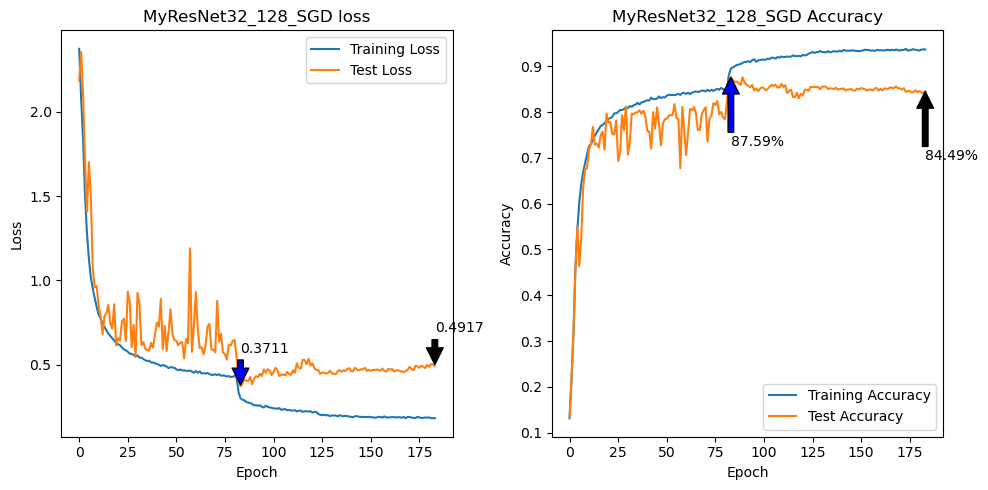

In [17]:
view = LogViewer(logs)
view.draw(save_name=file_name)

In [18]:
view.print_all()

1 epoch: train_loss=2.3735, train_acc=0.1314, test_loss=2.1853, test_acc=0.1333, lr=0.1000
2 epoch: train_loss=2.0798, train_acc=0.2148, test_loss=2.3546, test_acc=0.2218, lr=0.1000
3 epoch: train_loss=1.8352, train_acc=0.3153, test_loss=2.1068, test_acc=0.3182, lr=0.1000
4 epoch: train_loss=1.5061, train_acc=0.4579, test_loss=1.7083, test_acc=0.4561, lr=0.1000
5 epoch: train_loss=1.2799, train_acc=0.5432, test_loss=1.4064, test_acc=0.5487, lr=0.1000
6 epoch: train_loss=1.1260, train_acc=0.6035, test_loss=1.7006, test_acc=0.4635, lr=0.1000
7 epoch: train_loss=1.0174, train_acc=0.6424, test_loss=1.5005, test_acc=0.5257, lr=0.1000
8 epoch: train_loss=0.9513, train_acc=0.6692, test_loss=1.0685, test_acc=0.6346, lr=0.1000
9 epoch: train_loss=0.8944, train_acc=0.6888, test_loss=0.9583, test_acc=0.6755, lr=0.1000
10 epoch: train_loss=0.8420, train_acc=0.7080, test_loss=0.9658, test_acc=0.6772, lr=0.1000
11 epoch: train_loss=0.7979, train_acc=0.7254, test_loss=0.8477, test_acc=0.7189, lr=0.10